# Bone age prediction of hand radiographs using Neural Networks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzipping datasets

In [2]:
import os
import zipfile

# Define the data folder location
path = '/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/'
data_dirs = ['Bone Age Training Set', 'Bone Age Validation Set','Bone Age Test Set']
train_dirs = ['boneage-training-dataset', 'dataset_data_file_training-gt-6aaa9791-5bdc-4c6d-9ee9-5a3780a37103']
val_dirs = ['boneage-validation-dataset-1', 'boneage-validation-dataset-2']

# Extract data from zip file
for data_dir in data_dirs:
  if not os.path.exists(data_dir):
      with zipfile.ZipFile(path + data_dir + '.zip', 'r') as f:
          f.extractall('.')
  if 'Training' in data_dir: # training set has two more zip files
    for train_dir in train_dirs:
      if not os.path.exists(train_dir):
        with zipfile.ZipFile(data_dir + '/' + train_dir + '.zip', 'r') as f:
          f.extractall('.')
  if 'Validation' in data_dir: # validation set is divided in two more zip files
    for val_dir in val_dirs:
      if not os.path.exists(val_dir):
        with zipfile.ZipFile(data_dir + '/' + val_dir + '.zip', 'r') as f:
          f.extractall('.')

Importing libraries

In [4]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
np.random.seed(1)

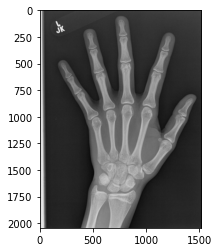

In [ ]:
plt.imshow(cv2.imread(train_dirs[0] + '/1377.png'))

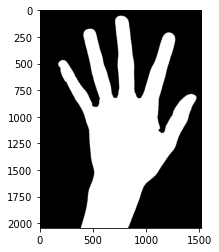

In [ ]:
masks_path = 'boneage-training-dataset-masks'
plt.imshow(cv2.imread(path + '/' + masks_path + '/1377.png'))

Mask an image as example

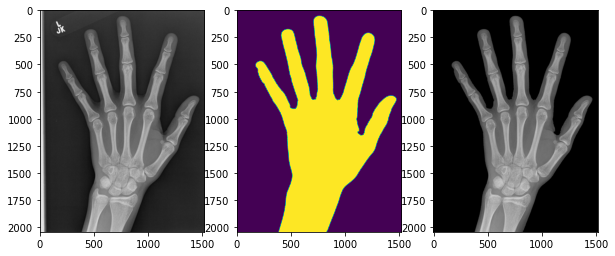

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10, 7))
image = cv2.imread(train_dirs[0] + '/1377.png')
mask = cv2.imread(path + '/' + masks_path + '/1377.png', 0) # 0 to read image in grayscale mode
ax[0].imshow(image)
ax[1].imshow(mask)
ax[2].imshow(cv2.bitwise_and(image, image, mask=mask))

### Data augmentation, Batching, Normalization : check LAB4 - ImageDataGenerator

### Loading filenames

In [86]:
def load_filenames(file, path, path_p=None):
  if 'Test' in file:
    df = pd.read_excel(file)
  else:
    df = pd.read_csv(file)

  # Uniforming the dfs
  # reorder columns
  if 'train' in file:
    df = df[['id', 'male', 'boneage']]
  
  # rename columns
  df.set_axis(['image', 'male', 'boneage'], axis=1, inplace=True)

  # changing values for gender
  df['male'].replace({'M':0, 'F':1}, inplace=True) # for test set only
  df['male'].replace({'True':0, 'False':1}, inplace=True) 

  # setting up the paths to get the images
  if path_p: # validation set images are divided in two folders
    mask_1 = df['image'] < 9727
    mask_2 = df['image'] >= 9727
    df['image'][mask_1] = path + '/' + df['image'][mask_1].astype(str) + '.png'
    df['image'][mask_2] = path_p + '/' + df['image'][mask_2].astype(str) + '.png'
  else: 
    df['image'] = path + '/' + df['image'].astype(str) + '.png'

  return df

In [87]:
# train_df = pd.read_csv('train.csv')
# validation_df = pd.read_csv(data_dirs[1] + '/Validation Dataset.csv')
# test_df = pd.read_excel(data_dirs[2] + '/Bone age ground truth.xlsx')
train_df = load_filenames('train.csv', train_dirs[0])
validation_df = load_filenames(data_dirs[1] + '/Validation Dataset.csv',
                               val_dirs[0], val_dirs[1])
test_df = load_filenames(data_dirs[2] + '/Bone age ground truth.xlsx',
                         data_dirs[2] + '/Test Set Images')

<ipython-input-86-e4782035534d>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'][mask_1] = path + '/' + df['image'][mask_1].astype(str) + '.png'
<ipython-input-86-e4782035534d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'][mask_2] = path_p + '/' + df['image'][mask_2].astype(str) + '.png'


In [88]:
display(train_df)
display(validation_df)
display(test_df)

,image,male,boneage
0,boneage-training-dataset/1377.png,False,180
1,boneage-training-dataset/1378.png,False,12
2,boneage-training-dataset/1379.png,False,94
3,boneage-training-dataset/1380.png,True,120
4,boneage-training-dataset/1381.png,False,82
...,...,...,...
12606,boneage-training-dataset/15605.png,False,50
12607,boneage-training-dataset/15606.png,False,113
12608,boneage-training-dataset/15608.png,False,55
12609,boneage-training-dataset/15609.png,True,150


,image,male,boneage
0,boneage-validation-dataset-1/1386.png,False,30
1,boneage-validation-dataset-1/1392.png,True,162
2,boneage-validation-dataset-1/1397.png,False,18
3,boneage-validation-dataset-1/1401.png,False,132
4,boneage-validation-dataset-1/1410.png,True,57
...,...,...,...
1420,boneage-validation-dataset-2/15592.png,False,42
1421,boneage-validation-dataset-2/15601.png,False,132
1422,boneage-validation-dataset-2/15607.png,True,186
1423,boneage-validation-dataset-2/15611.png,False,120


,image,male,boneage
0,Bone Age Test Set/Test Set Images/4360.png,0,168.934249
1,Bone Age Test Set/Test Set Images/4361.png,0,169.652678
2,Bone Age Test Set/Test Set Images/4362.png,0,73.256112
3,Bone Age Test Set/Test Set Images/4363.png,0,152.862669
4,Bone Age Test Set/Test Set Images/4364.png,0,135.456954
...,...,...,...
195,Bone Age Test Set/Test Set Images/4555.png,1,133.486757
196,Bone Age Test Set/Test Set Images/4556.png,1,129.254493
197,Bone Age Test Set/Test Set Images/4557.png,1,167.685033
198,Bone Age Test Set/Test Set Images/4558.png,1,135.980312


### Create the datasets

Bring this two functions below inside a .py file and import it

In [24]:
def load_hand_image(img_name):
    num_row = 524
    num_col = 524

    if isinstance(img_name, bytes):
        img_name = img_name.decode()

    img = cv2.imread(img_name, cv2.IMREAD_COLOR)
    img = np.array(cv2.resize(img, (num_row, num_col)), dtype='float32')
    plt.imshow(img)

    return img

In [19]:
def normalize_img(image):
    return tf.cast(image, tf.float32) / 255.

In [17]:
# def create_dataset(file_names, batch_size, shuffle, cache_file=None):
def create_dataset(path, file_names, batch_size, shuffle, cache_file=None):
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices(file_names)

    # Map the load_malaria_image function
    # py_func = lambda file_name: (tf.numpy_function(load_hand_image, [file_name], tf.float32))
    py_func = lambda file_name: (tf.numpy_function(load_hand_image, [path + file_name], tf.float32))
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Map the normalize_img function
    dataset = dataset.map(normalize_img, num_parallel_calls=os.cpu_count())

    # Duplicate data for the autoencoder. Hint: input = img, output = (img, img)
    py_funct = lambda img: (img, img)
    dataset = dataset.map(py_funct, num_parallel_calls=os.cpu_count())

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [89]:
batch_size = 32
train_dataset = create_dataset(train_df['image'],
                               batch_size=batch_size,
                               shuffle=True,
                               cache_file='train_cache')

val_dataset = create_dataset(validation_df['image'],
                              batch_size=batch_size,
                              shuffle=False,
                              cache_file='val_cache')

test_dataset = create_dataset(test_df['image'],
                              batch_size=batch_size,
                              shuffle=False,
                              cache_file='test_cache')

train_steps = int(np.ceil(train_df.shape[0] / batch_size))
val_steps = int(np.ceil(validation_df.shape[0] / batch_size))
test_steps = int(np.ceil(test_df.shape[0] / batch_size))